# Pet Breet Detection

This is my implementation of using a pretrained ResNet34 model on image net to do classification on Pet dataset. The dataset contains 37 breeds of pets (12 cat breeds and 25 dogs breeds).

## Dataset

For fine tuning  the model we will use the The [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/).
It was made available in 2012 by  O. M. Parkhi et al. Around 7400 images are included in the dataset. It is about 750MB in size and can be
downloaded from this [link](http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz).

## Loading the Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time

In PyTorch, all pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least ```224```. The images have to be loaded in to a range of [0, 1] and then normalized using ```mean = [0.485, 0.456, 0.406]``` and ```std = [0.229, 0.224, 0.225]```.

In [2]:
from torchvision import transforms
normalize = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In this dataset, the finename contains the target category e.g. ```basset_hound_86.jpg```. We will use a regular expression to extract the category name.

In [3]:
import re
pattern = '(.+)_\d+.jpg$'

In [132]:
from PIL import Image

X = [] #images stored as np array
y = [] #class labels (0 to 37)
categories = {}

classes = 0
current_path = os.getcwd()

path = os.path.join(current_path, 'data')
images = os.listdir(path)
    
for img_name in images:
    image = Image.open(path + '\\' + img_name)
    cat = re.match(pattern, img_name).group(1)
    if cat not in categories.values():
        categories[classes] = cat
        classes += 1
    try:
        input_tensor = normalize(image).numpy()
        X.append(input_tensor)
        y.append(categories[cat])  
    except:
        pass

X = np.array(X)
y = np.array(y)

In [5]:
# shape of training data
X.shape

(7378, 3, 224, 224)

## Train/Test Split

At this point, it is a good idea to split the data into training data and testing data where the former is used in training the model while the later is used to evaluate its performance on unseen data before deploying it into a production environment.

In [58]:
from sklearn.model_selection import train_test_split

In [59]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,stratify=y, random_state=113)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_val.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_val.shape}")

X_train shape: (5902, 3, 224, 224)
X_test shape: (1476, 3, 224, 224)
y_train shape: (5902,)
y_test shape: (1476,)


## Building the Model

to classify the images we will use a pretrained ResNet34 model and replace the final layer. We will freeze all the weights except for the final layer and only train these weights.

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torchvision import models

In [192]:
model = models.resnet34(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Freeze all the layers

In [194]:
for param in model.parameters():
    param.requires_grad = False

we can now replace the last fully connected layer

In [195]:
n_inputs = model.fc.in_features
model.fc =  nn.Linear(n_inputs, classes)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Train the model

we will train the model using batch size of 64 and for 5 epochs

In [196]:
batch_size = 64

In [197]:
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).long()
X_val_tensor = torch.from_numpy(X_val).float()
y_val_tensor = torch.from_numpy(y_val).long()
train_data = TensorDataset(X_train_tensor, y_train_tensor)
val_data = TensorDataset(X_val_tensor, y_val_tensor)
train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size)
val_dataloader = DataLoader(dataset=val_data, batch_size=batch_size)
dataloaders = {'train': train_dataloader, 'val':val_dataloader}
dataset_sizes = {'train': len(X_train), 'val': len(X_val)}

In [198]:
# Gather the parameters to be optimized/updated in this run.
# we will only update the parameters that we have just initialized
params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

	 fc.weight
	 fc.bias


we will use the cross entroy loss and the adam optimizer

In [199]:
model.to('cuda')
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

In [200]:
def train_model(model, criterion, optimizer, dataset_sizes, bs, num_epochs=15):
    
    since = time.time()
    epoch_loss = []
    epoch_acc = []
    
    print_every = int((dataset_sizes['train']/bs)/10)
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            i = 0
            running_loss = 0.0
            running_corrects = 0
            
            if phase == 'train':
                 print(f'\rProgress:',end='')
                       
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:

                inputs = inputs.to('cuda')
                labels = labels.to('cuda')
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data).item()
               
                if phase == 'train' and i % print_every == print_every - 1:
                    print(f"\rProgress: [{'='*((i+1)//print_every)}] ",end='')
                          
                i += 1
                          
            epoch_loss.append(running_loss / dataset_sizes[phase])
            epoch_acc.append(running_corrects/dataset_sizes[phase])

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss[-1], epoch_acc[-1]))

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    return epoch_loss, epoch_acc

In [201]:
epoch_loss, epoch_acc = train_model(model, criterion, optimizer, dataset_sizes, batch_size, num_epochs=5)

Epoch 0/4
----------
Progress: [==========] train Loss: 0.0437 Acc: 0.3783
val Loss: 0.0283 Acc: 0.7439

Epoch 1/4
----------
Progress: [==========] train Loss: 0.0210 Acc: 0.8096
val Loss: 0.0160 Acc: 0.8604

Epoch 2/4
----------
Progress: [==========] train Loss: 0.0135 Acc: 0.8738
val Loss: 0.0118 Acc: 0.8794

Epoch 3/4
----------
Progress: [==========] train Loss: 0.0104 Acc: 0.8933
val Loss: 0.0097 Acc: 0.8882

Epoch 4/4
----------
Progress: [==========] train Loss: 0.0088 Acc: 0.9065
val Loss: 0.0085 Acc: 0.8916

Training complete in 7m 53s


our model got 90% accuracy on the training dataset. we can plot a graph of the loss and accuracy as they progress over the epochs. 

In [202]:
# plot loss
accuracy = epoch_acc[::2]
val_accuracy = epoch_acc[1::2]
loss = epoch_loss[::2]
val_loss = epoch_loss[1::2]

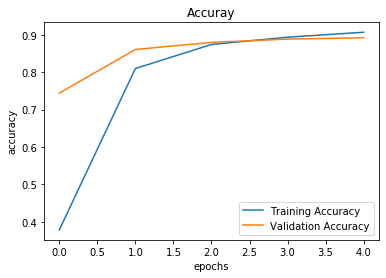

In [203]:
#plot accuracy
plt.figure()
plt.plot(accuracy, label = 'Training Accuracy')
plt.plot(val_accuracy, label = 'Validation Accuracy')
plt.title('Accuray')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

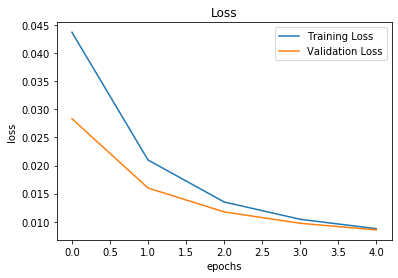

In [204]:
#plot loss
plt.figure()
plt.plot(loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

## Visualizing Images

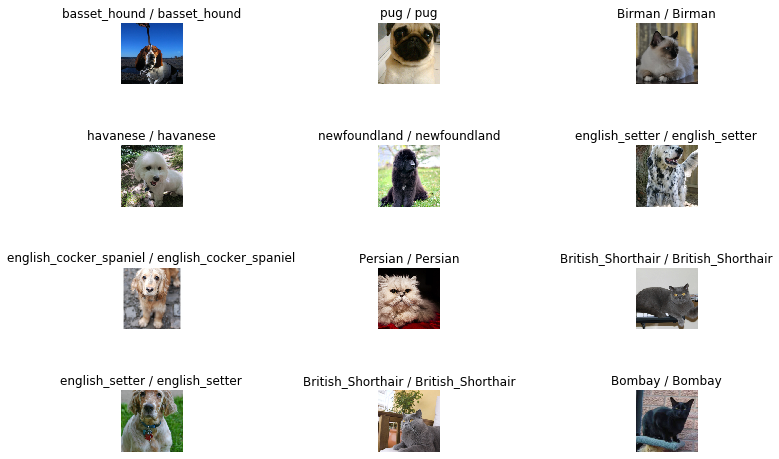

In [205]:
def visualize_image(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    
def visualize_model(model, num_images=12):
    model.eval()
    images_so_far = 0
    fig, _ = plt.subplots(nrows=4, ncols=4)
    fig.tight_layout()
    plt.subplots_adjust(left=0.01, bottom=0.01, right=1.5, top=1.5, wspace=1.0, hspace=1.0)

    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to('cuda')
            labels = labels.to('cuda')

            outputs = model(inputs)
            conf, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//3, 3, images_so_far)
                ax.axis('off')
                ax.set_title('{} / {}'.format(categories[preds[j].item()], 
                                                                   categories[labels[j].item()]))
                visualize_image(inputs.cpu().data[j])

                if images_so_far == num_images:
                    return
                
visualize_model(model)